<a href="https://colab.research.google.com/github/britt-klose/GENAI-HW3/blob/main/HW3problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gen AI Assignment 3

Brittany Klose

10/12/24

Tasks

* Task 1: Load and Preprocess the SVHN Dataset
* Task 2: Build a Variational Autoencoder
* Task 3: Train the VAE with Different Latent Dimensions
* Task 4: Visualize the Results

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

In [2]:
#@title 0. Parameters

IMAGE_SIZE = 32
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 50
BETA = 500

In [3]:
#@title 1. Prepare the data

!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

from scipy.io import loadmat

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

--2024-12-14 23:49:17--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  86.7MB/s    in 2.0s    

2024-12-14 23:49:19 (86.7 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-12-14 23:49:20--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  39.8MB/s    in 1.5s    

2024-12-14 23:49:21 (39.8 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [4]:
#@title Build the variational autoencoder

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [5]:
# Encoder
def build_vae(latent_dim):
  encoder_input = layers.Input(
      shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="encoder_input"
  )
  x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
      encoder_input
  )
  x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
  shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

  x = layers.Flatten()(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()


  # Decoder

  decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
  x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
  x = layers.Reshape(shape_before_flattening)(x)
  x = layers.Conv2DTranspose(
      128, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  x = layers.Conv2DTranspose(
      64, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  x = layers.Conv2DTranspose(
      32, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  decoder_output = layers.Conv2D(
      3,
      (3, 3),
      strides=1,
      activation="sigmoid",
      padding="same",
      name="decoder_output",
  )(x)

  decoder = models.Model(decoder_input, decoder_output)
  decoder.summary()

  # Create a variational autoencoder
  vae = VAE(encoder, decoder)
  return vae

In [6]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [7]:
#@title 3.1 Train the variational autoencoder
# Compile the variational autoencoder
def main():
  latent_dims = [2, 5, 10]
  global vae
  for dim in latent_dims:
      print(f'Training VAE with latent dimension: {dim}')
      vae = build_vae(latent_dim=dim)
      vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
      vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, x_test))

main()

Training VAE with latent dimension: 2


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 101,444 (396.27 KB)

 Trainable params: 101,444 (396.27 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - kl_loss: 1.2661 - reconstruction_loss: 334.7359 - total_loss: 336.0019 - val_kl_loss: 2.9486 - val_loss: 311.9617 - val_reconstruction_loss: 309.0131
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - kl_loss: 2.7531 - reconstruction_loss: 318.6179 - total_loss: 321.3709 - val_kl_loss: 2.9866 - val_loss: 311.7377 - val_reconstruction_loss: 308.7510
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - kl_loss: 2.7690 - reconstruction_loss: 318.2364 - total_loss: 321.0052 - val_kl_loss: 2.9299 - val_loss: 311.4609 - val_reconstruction_loss: 308.5310
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - kl_loss: 2.7977 - reconstruction_loss: 318.1112 - total_loss: 320.9090 - val_kl_loss: 2.9684 - val_loss: 311.5031 - val_reconstruction_loss: 308.5348
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - kl_loss: 2.8151 - reconstruction_loss: 318.3852 - total_loss: 321.2003 - val_kl_loss: 3.1190 - val_loss: 311.5625 - val_reco

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2048)           │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 5)              │         10,245 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 5)              │         10,245 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 5)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │          12,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,995 (988.26 KB)

 Trainable params: 252,995 (988.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - kl_loss: 1.4343 - reconstruction_loss: 334.7025 - total_loss: 336.1370 - val_kl_loss: 3.1001 - val_loss: 318.2628 - val_reconstruction_loss: 315.1627
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - kl_loss: 2.9423 - reconstruction_loss: 322.3977 - total_loss: 325.3401 - val_kl_loss: 4.3767 - val_loss: 309.5574 - val_reconstruction_loss: 305.1807
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - kl_loss: 4.1424 - reconstruction_loss: 315.3778 - total_loss: 319.5201 - val_kl_loss: 4.5478 - val_loss: 309.2086 - val_reconstruction_loss: 304.6608
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - kl_loss: 4.1839 - reconstruction_loss: 315.3842 - total_loss: 319.5680 - val_kl_loss: 4.6898 - val_loss: 309.5926 - val_reconstruction_loss: 304.9028
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - kl_loss: 4.3299 - reconstruction_loss: 314.8393 - total_loss: 319.1691 - val_kl_loss: 5.0129 - val_loss: 308.8450 - val_rec

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2048)           │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │         20,490 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │         20,490 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 134,228 (524.33 KB)

 Trainable params: 134,228 (524.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │          22,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,235 (1.00 MB)

 Trainable params: 263,235 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - kl_loss: 1.5759 - reconstruction_loss: 333.7790 - total_loss: 335.3548 - val_kl_loss: 3.8839 - val_loss: 310.7390 - val_reconstruction_loss: 306.8550
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - kl_loss: 3.5030 - reconstruction_loss: 317.1618 - total_loss: 320.6649 - val_kl_loss: 4.2745 - val_loss: 309.6439 - val_reconstruction_loss: 305.3694
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - kl_loss: 4.1110 - reconstruction_loss: 315.3070 - total_loss: 319.4180 - val_kl_loss: 4.6811 - val_loss: 309.3006 - val_reconstruction_loss: 304.6195
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - kl_loss: 4.2526 - reconstruction_loss: 315.1536 - total_loss: 319.4062 - val_kl_loss: 4.9413 - val_loss: 308.8671 - val_reconstruction_loss: 303.9258
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - kl_loss: 4.5888 - reconstruction_loss: 314.5642 - total_loss: 319.1530 - val_kl_loss: 5.2510 - val_loss: 308.7575 - val_rec

In [8]:
#@title 4. Reconstruct using the variational autoencoder
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [9]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real house numbers")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Example real house numbers


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.29733098, 0.29218873, 0.28267774],
         [0.2934709 , 0.2903388 , 0.2753331 ],
         [0.29201615, 0.28533348, 0.26964715],
         ...,
         [0.23603363, 0.23193006, 0.2308512 ],
         [0.2340486 , 0.22936043, 0.22878255],
         [0.2341291 , 0.22952208, 0.22636151]],

        [[0.29109055, 0.28726253, 0.2793457 ],
         [0.2903947 , 0.29196262, 0.27617878],
         [0.2903363 , 0.2906908 , 0.27422038],
         ...,
         [0.22988796, 0.23196074, 0.23075716],
         [0.224501  , 0.22471577, 0.22545025],
         [0.22733505, 0.22488447, 0.22257271]],

        [[0.28815272, 0.28656244, 0.27445003],
         [0.290055  , 0.28991583, 0.27454308],
         [0.29060882, 0.28702453, 0.27447656],
         ...,
         [0.22738142, 0.22733384, 0.22600695],
         [0.2203057 , 0.21990424, 0.22578025],
         [0.22166677, 0.22063278, 0.22194597]],

        ...,

        [[0.29252666, 0.29372755, 0.28645998],
         [0.28985277, 0.29516417, 0.28473338]

In [10]:
# Encode the example images
z_mean, z_var, z = vae.encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [11]:
# Some examples of the embeddings
print(z[:10])

[[-1.4206152  -2.3160064   0.49431956  1.1262794  -1.1498219  -1.1689036
   1.0603718   0.13711053 -1.3391263   0.00620987]
 [-0.33692214  1.5076296   0.11919791 -0.21707875 -1.1376989  -0.16318548
   0.5179543  -0.34116584  1.0001731   0.5801505 ]
 [-0.04722464 -0.12345081  1.0285238   0.28640485 -0.6852562   0.9230807
   0.12276725 -0.81748146  0.96780217 -0.4209784 ]
 [ 1.0318723   0.10547379  0.6008512  -1.1537045  -0.7149501  -0.07888639
  -0.40196943  0.06426787  0.6419984   0.60109603]
 [-0.10461214 -1.1501231   1.6065378   0.7964823  -0.06329708 -0.14789855
  -0.23134857  0.31869674  0.85426027 -1.0023937 ]
 [-0.01899128 -1.0371621  -0.46643433  1.0575755  -0.6316407   0.9255352
   0.706532    0.13730666 -0.32296833  0.5722086 ]
 [-0.21223088 -0.45205814  0.64390904 -0.856671   -1.3147627   0.15981063
  -0.38731956 -0.03422172 -3.0733647   0.14435153]
 [-1.646122    0.8210487  -0.73524344 -2.3439882  -1.0064912  -0.6501417
  -2.5273209  -0.5007229  -1.3619255  -0.58748657]
 [ 1

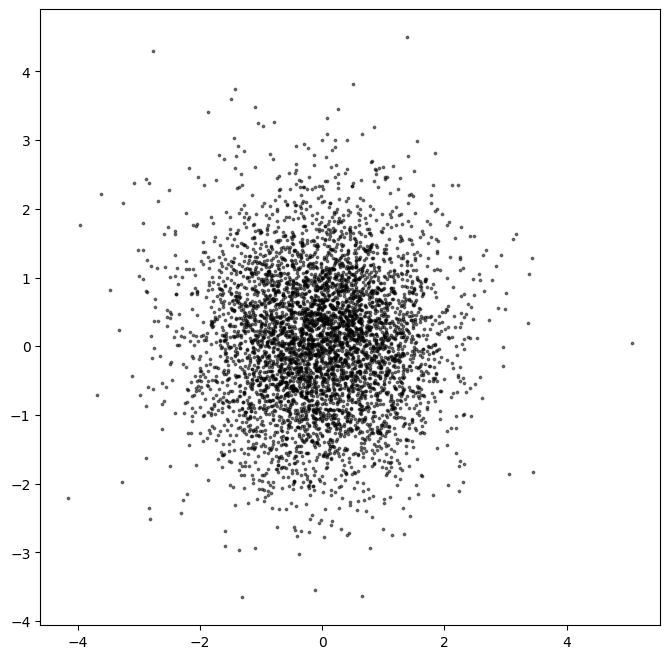

In [12]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [13]:
#@title 5. Generate using the decoder
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 10))

In [14]:
# Decode the sampled points
reconstructions = vae.decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


In [15]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

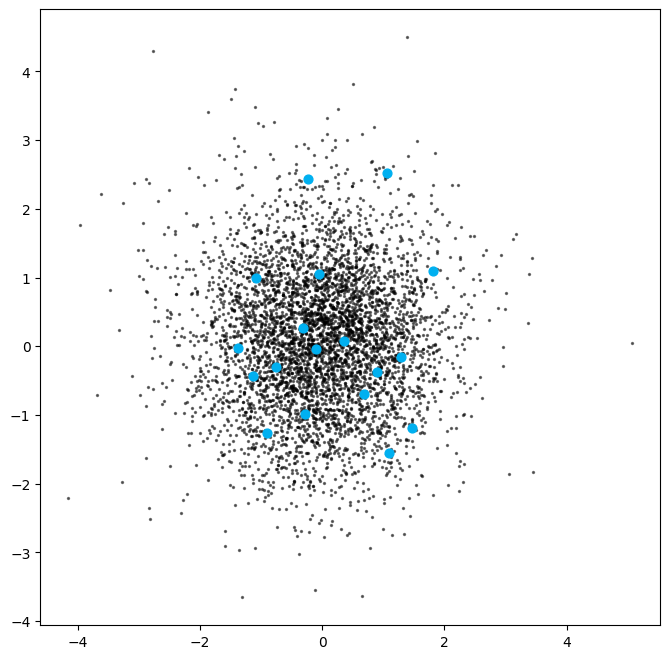

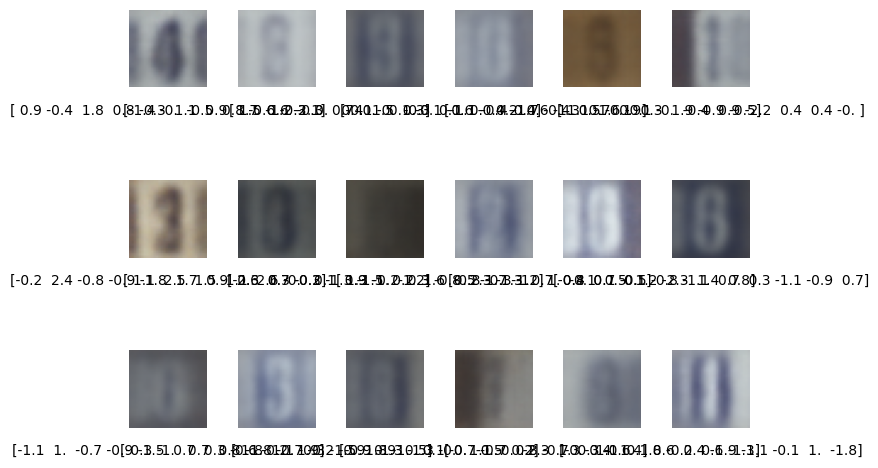

In [16]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

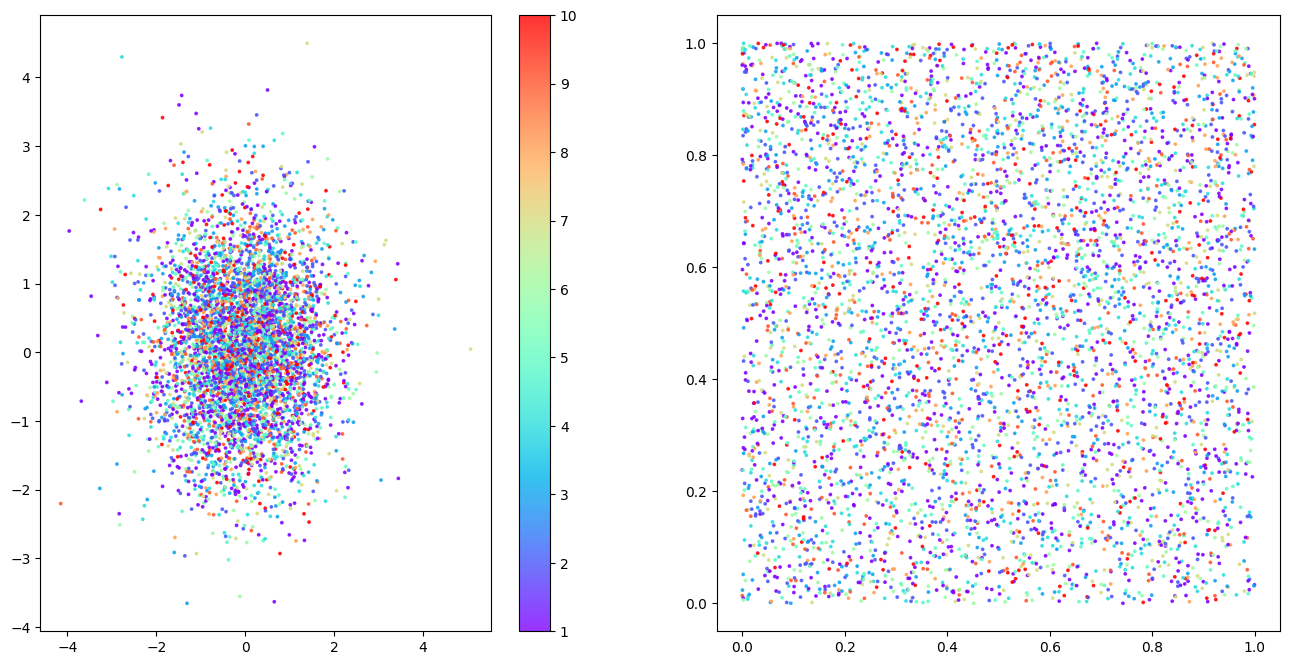

In [17]:
#@title 6. Explore the latent space
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


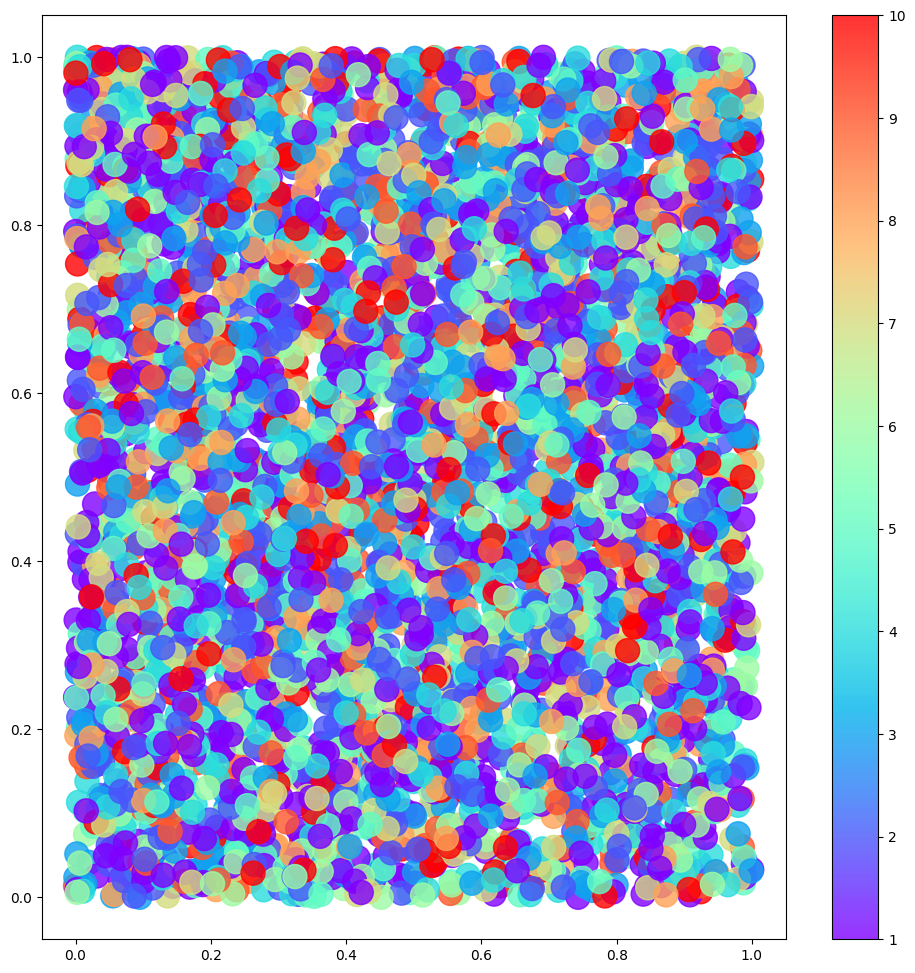

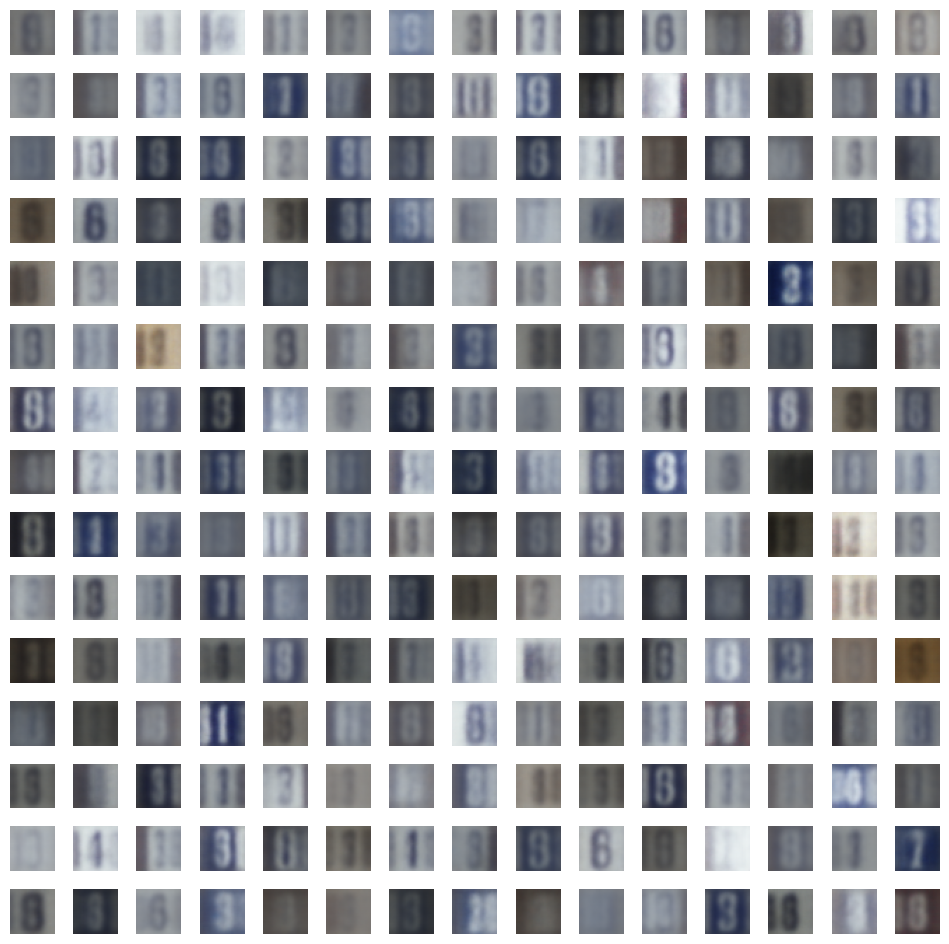

In [23]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
#grid = np.array(list(zip(xv, yv)))
latent_dim = 10 # Update if a different latent dimension was used in training
grid = np.random.normal(size=(grid_size * grid_size, latent_dim))

reconstructions = vae.decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Discussion Points:

* Clarity: How well does the VAE capture the structure of the numbers?
  * The quality of generated images varied. Overall it wasn't fantastically clear, but the original dataset included blury or faded numbers so it is hard to say for sure if the remade images are blury or just replicating the original's quality. To elaborate, some images were better than others. Some were very blurry or too dark or too light and I could not see the number well or at all. But then there were plenty of numbers that I could read perfectly fine.
* Distortion: Are there significant distortions?
  * I wouldn't say there were any major distortions between the original dataset images and the generated ones aside from differences due to clarity. Any numbers that weren't fully formed seemed to be from being too faded or dark than from being distorted.
* Variability: Does the model maintain a consistent performance across different styles and backgrounds of digits?
  * The model did not perform very great in variability. There is diversity of color and maybe slight variation in size but for the most part the font and styles all look essentially the same. I'm not sure why this is the case. Maybe there was a larger quantity of this style in the original set.
* Generalization: The ability of the VAE to generate coherent reconstructions of unseen digits.
  * Overall I would say this VAE model was successful in generating mostly coherent reconstructions of the original data. I was able to produce at least a few new numbers that could have been part of the original.